# Análisis exploratorio de datos + regresión logitica y predicción

## EDA

1. Limpieza de datos
2. Feature engineer

In [57]:
# Librerías
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [58]:
df1 = pd.read_parquet(r'C:\Users\nuria\OneDrive\Escritorio\Data Science\DS102024\3-MachineLearning\2-Supervisado\1-Clasificacion\train.parquet')
df1.head(3)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,599,Dell,Inspiron 3179,2 in 1 Convertible,11.6,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,4GB,128GB SSD,Intel HD Graphics 615,Windows 10,1.39kg,603.0
1,92,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,Gaming,15.6,Full HD 1920x1080,AMD FX 9830P 3GHz,8GB,1TB HDD,AMD Radeon RX 560,Windows 10,2.45kg,699.0
2,744,HP,ZBook 15,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD,Nvidia Quadro M2200,Windows 10,2.6kg,2419.0


Limpieza y división de columnas
Puedo:
- Clasificar por compañías (company)
- Clasificar por producto (product) ¿?
- Agrupar por tipos (TypeName)!!
- Agrupar por inches ¿?
- Agrupar por cpu
- Agrupar por ram 
- Agrupar por memoria
- Gpu
- Agrupar por sistema operativo (opsys)!!
- Rangos de peso y precio

LAS COLUMNAS IMPORTANTES PARA LA PREDICCIÓN HAY QUE PASARLAS A NUMÉRICAS

### Primera observación

In [59]:
df1.shape

(912, 13)

In [60]:
df1.columns

Index(['laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight',
       'Price_euros'],
      dtype='object')

In [61]:
df1.tail()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
907,837,Acer,Chromebook 11,Netbook,11.6,IPS Panel 1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,32GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.35kg,355.00
908,626,Acer,CB5-132T-C9KK (N3160/4GB/32GB/Chrome,2 in 1 Convertible,11.6,IPS Panel Touchscreen 1366x768,Intel Celeron Quad Core N3160 1.6GHz,4GB,32GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.25kg,379.00
909,225,Dell,Inspiron 3576,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 520,Linux,2.2kg,677.35
910,17,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,AMD Radeon R5 M430,Windows 10,2.2kg,745.00
911,87,Dell,Inspiron 7577,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows 10,2.65kg,1349.00


In [62]:
df1.describe()

,laptop_ID,Price_euros
count,912.000000,912.000000
mean,663.118421,1111.262533
std,380.713558,682.109694
min,1.000000,174.000000
25%,339.750000,598.742500
50%,666.500000,977.000000
75%,985.250000,1472.650000
max,1320.000000,5499.000000


In [63]:
# Observamos que tenga valores duplicados
df1[df1.duplicated(keep = False)] 

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros


In [64]:
df1.isnull().sum()

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

### Análisis exploratorio

In [65]:
# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy import stats

# Estadística 
import scipy

In [66]:
# Crear un DataFrame vacío
summary_df = pd.DataFrame(columns=[
    'Nombre de la variable', 
    'Tipo de dato', 
    'Tipo de variable', 
    'Cardinalidad', 
    'Distribución', 
    'Valores faltantes (cantidad)', 
    'Valores faltantes (%)', 
    'Outliers (cantidad)', 
    'Outliers (%)', 
    'Rango de valores', 
    'Moda', 
    'Media', 
    'Mediana', 
    'Asimetría', 
    'Curtosis', 
    'Resultados de pruebas de normalidad'
])

# Función para calcular el resumen de cada variable
def summarize_variable(col):
    data_type = col.dtype
    variable_type = 'numérica' if np.issubdtype(data_type, np.number) else 'categórica'
    cardinality = col.nunique()
    normality_test_result = 'N/A'

    if np.issubdtype(data_type, np.number):
        # Test de K-S
        d_statistic, p_value = stats.kstest(col.dropna(), 'norm', args=(col.mean(), col.std()))
        normality_test_result = 'Normal' if p_value > 0.05 else 'No normal'
        distribution = 'Gaussiana' if normality_test_result == 'Normal' else 'No gaussiana'
    else:
        distribution = 'Categórica'
    
    # Valores faltantes
    missing_count = col.isnull().sum()
    missing_percentage = missing_count / len(col) * 100
    
    # Outliers
    if np.issubdtype(data_type, np.number):
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = col[(col < lower_bound) | (col > upper_bound)]
        outliers_count = outliers.count()
        outliers_percentage = outliers_count / len(col) * 100
    else:
        outliers_count = 0
        outliers_percentage = 0

    value_range = f"{col.min()} - {col.max()}" if np.issubdtype(data_type, np.number) else 'N/A'
    
    mode = col.mode()[0] if variable_type == 'categórica' else col.mode().values[0]
    mean = col.mean() if variable_type == 'numérica' else 'N/A'
    median = col.median() if variable_type == 'numérica' else 'N/A'
    skewness = col.skew() if variable_type == 'numérica' else 'N/A'
    kurtosis = col.kurtosis() if variable_type == 'numérica' else 'N/A'

    summary_df.loc[len(summary_df)] = [
        col.name, 
        data_type, 
        variable_type, 
        cardinality, 
        distribution, 
        missing_count, 
        missing_percentage, 
        outliers_count, 
        outliers_percentage, 
        value_range, 
        mode, 
        mean, 
        median, 
        skewness, 
        kurtosis, 
        normality_test_result
    ]

# Resumir cada variable en el DataFrame
for column in df1.columns:
    summarize_variable(df1[column])

# Configurar el DataFrame para mejor visualización
summary_df.set_index('Nombre de la variable', inplace=True)
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Evitar el truncado de filas

# Mostrar el resumen en formato DataFrame
import IPython.display as display
display.display(summary_df)


,Tipo de dato,Tipo de variable,Cardinalidad,Distribución,Valores faltantes (cantidad),Valores faltantes (%),Outliers (cantidad),Outliers (%),Rango de valores,Moda,Media,Mediana,Asimetría,Curtosis,Resultados de pruebas de normalidad
Nombre de la variable,,,,,,,,,,,,,,,
laptop_ID,int64,numérica,912,No gaussiana,0,0.0,0,0.000000,1 - 1320,1,663.118421,666.5,-0.014928,-1.17105,No normal
Company,object,categórica,19,Categórica,0,0.0,0,0.000000,N/A,Dell,N/A,N/A,N/A,N/A,N/A
Product,object,categórica,484,Categórica,0,0.0,0,0.000000,N/A,XPS 13,N/A,N/A,N/A,N/A,N/A
TypeName,object,categórica,6,Categórica,0,0.0,0,0.000000,N/A,Notebook,N/A,N/A,N/A,N/A,N/A
Inches,object,categórica,18,Categórica,0,0.0,0,0.000000,N/A,15.6,N/A,N/A,N/A,N/A,N/A
ScreenResolution,object,categórica,38,Categórica,0,0.0,0,0.000000,N/A,Full HD 1920x1080,N/A,N/A,N/A,N/A,N/A
Cpu,object,categórica,104,Categórica,0,0.0,0,0.000000,N/A,Intel Core i5 7200U 2.5GHz,N/A,N/A,N/A,N/A,N/A
Ram,object,categórica,9,Categórica,0,0.0,0,0.000000,N/A,8GB,N/A,N/A,N/A,N/A,N/A
Memory,object,categórica,34,Categórica,0,0.0,0,0.000000,N/A,256GB SSD,N/A,N/A,N/A,N/A,N/A


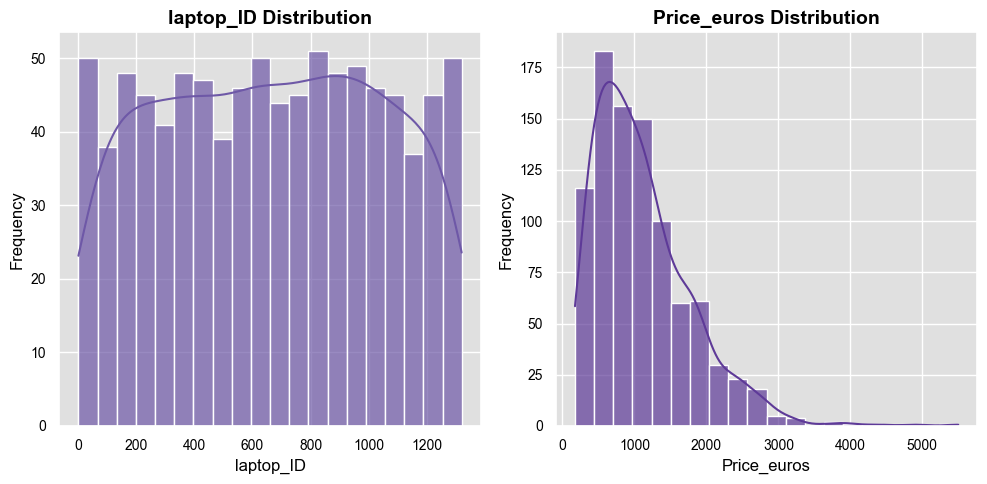

In [68]:
import warnings
warnings.filterwarnings("ignore")
# Get numerical columns and exclude 'id'
numerical_columns = df1.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col.lower() != 'id']

# Set a seaborn style for the plot
sns.set(style="darkgrid")

# Set up the figure size for numerical column distribution plots
num_cols = len(numerical_columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)

# Set up the figure size and grid for subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5 * num_rows))
axes = axes.flatten()
# List of purple tones for the colors, using a light and dark mix
colors = sns.color_palette("Purples", num_cols)

# Modify the first 3 colors to be darker
dark_colors = sns.color_palette("Purples", 10)[7:10]  # Dark purples for the first three columns
colors[:3] = dark_colors  # Assign dark colors to the first three

# Plot numerical columns (Distribution)
for i, col in enumerate(numerical_columns):
    sns.histplot(df1[col], kde=True, bins=20, color=colors[i], ax=axes[i], alpha=0.7)
    axes[i].set_title(f'{col} Distribution', fontsize=14, fontweight='bold', color='black')
    axes[i].set_xlabel(col, fontsize=12, color='black')
    axes[i].set_ylabel('Frequency', fontsize=12, color='black')
    axes[i].tick_params(axis='both', which='major', labelsize=10, colors='black')
    axes[i].set_facecolor('#e0e0e0')  # Light gray background for each subplot

# Remove any empty subplots if the number of columns isn't a multiple of 3
for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Pruebas de normalidad

Prueba de Shapiro-Wilk para laptop_ID: Estadística=0.957, p-valor=0.000
La muestra no parece provenir de una distribución normal (se rechaza H0) para laptop_ID.



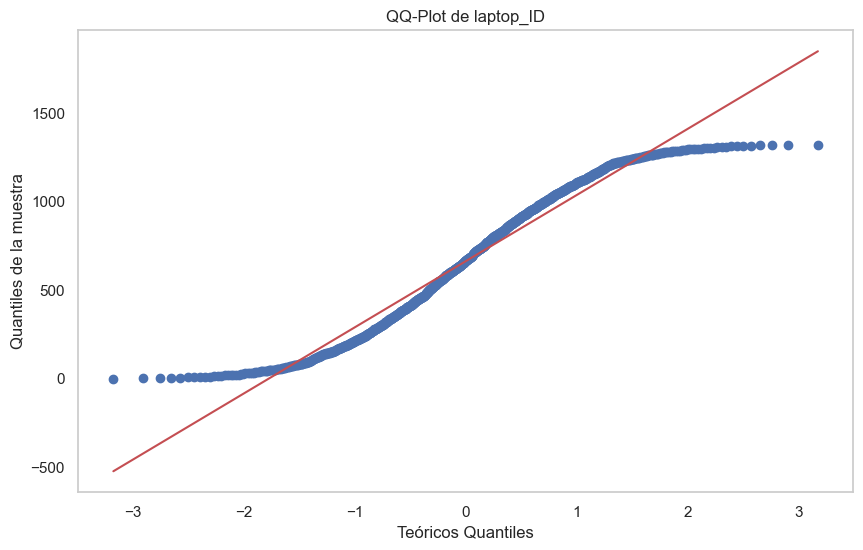

Prueba de Shapiro-Wilk para Price_euros: Estadística=0.898, p-valor=0.000
La muestra no parece provenir de una distribución normal (se rechaza H0) para Price_euros.



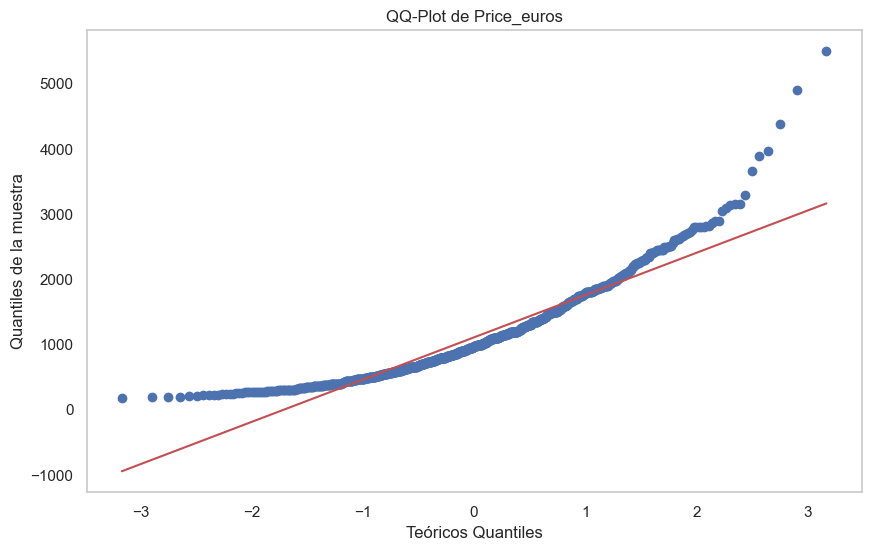

In [69]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")
numeric_columns = df1.select_dtypes(include=['float64', 'int64']).columns
# Iterar sobre las columnas numéricas
for column in numeric_columns:
    # Calcular la prueba de Shapiro-Wilk
    stat, p_value = stats.shapiro(df1[column].dropna())
    
    # Mostrar el resultado de la prueba
    print(f'Prueba de Shapiro-Wilk para {column}: Estadística={stat:.3f}, p-valor={p_value:.3f}')
    
    # Interpretar el resultado
    alpha = 0.05
    if p_value > alpha:
        print(f'La muestra parece provenir de una distribución normal (no se rechaza H0) para {column}.\n')
    else:
        print(f'La muestra no parece provenir de una distribución normal (se rechaza H0) para {column}.\n')
    
    # Graficar el QQ-Plot
    plt.figure(figsize=(10, 6))
    stats.probplot(df1[column].dropna(), dist="norm", plot=plt)
    plt.title(f'QQ-Plot de {column}')
    plt.xlabel('Teóricos Quantiles')
    plt.ylabel('Quantiles de la muestra')
    plt.grid()
    plt.show()

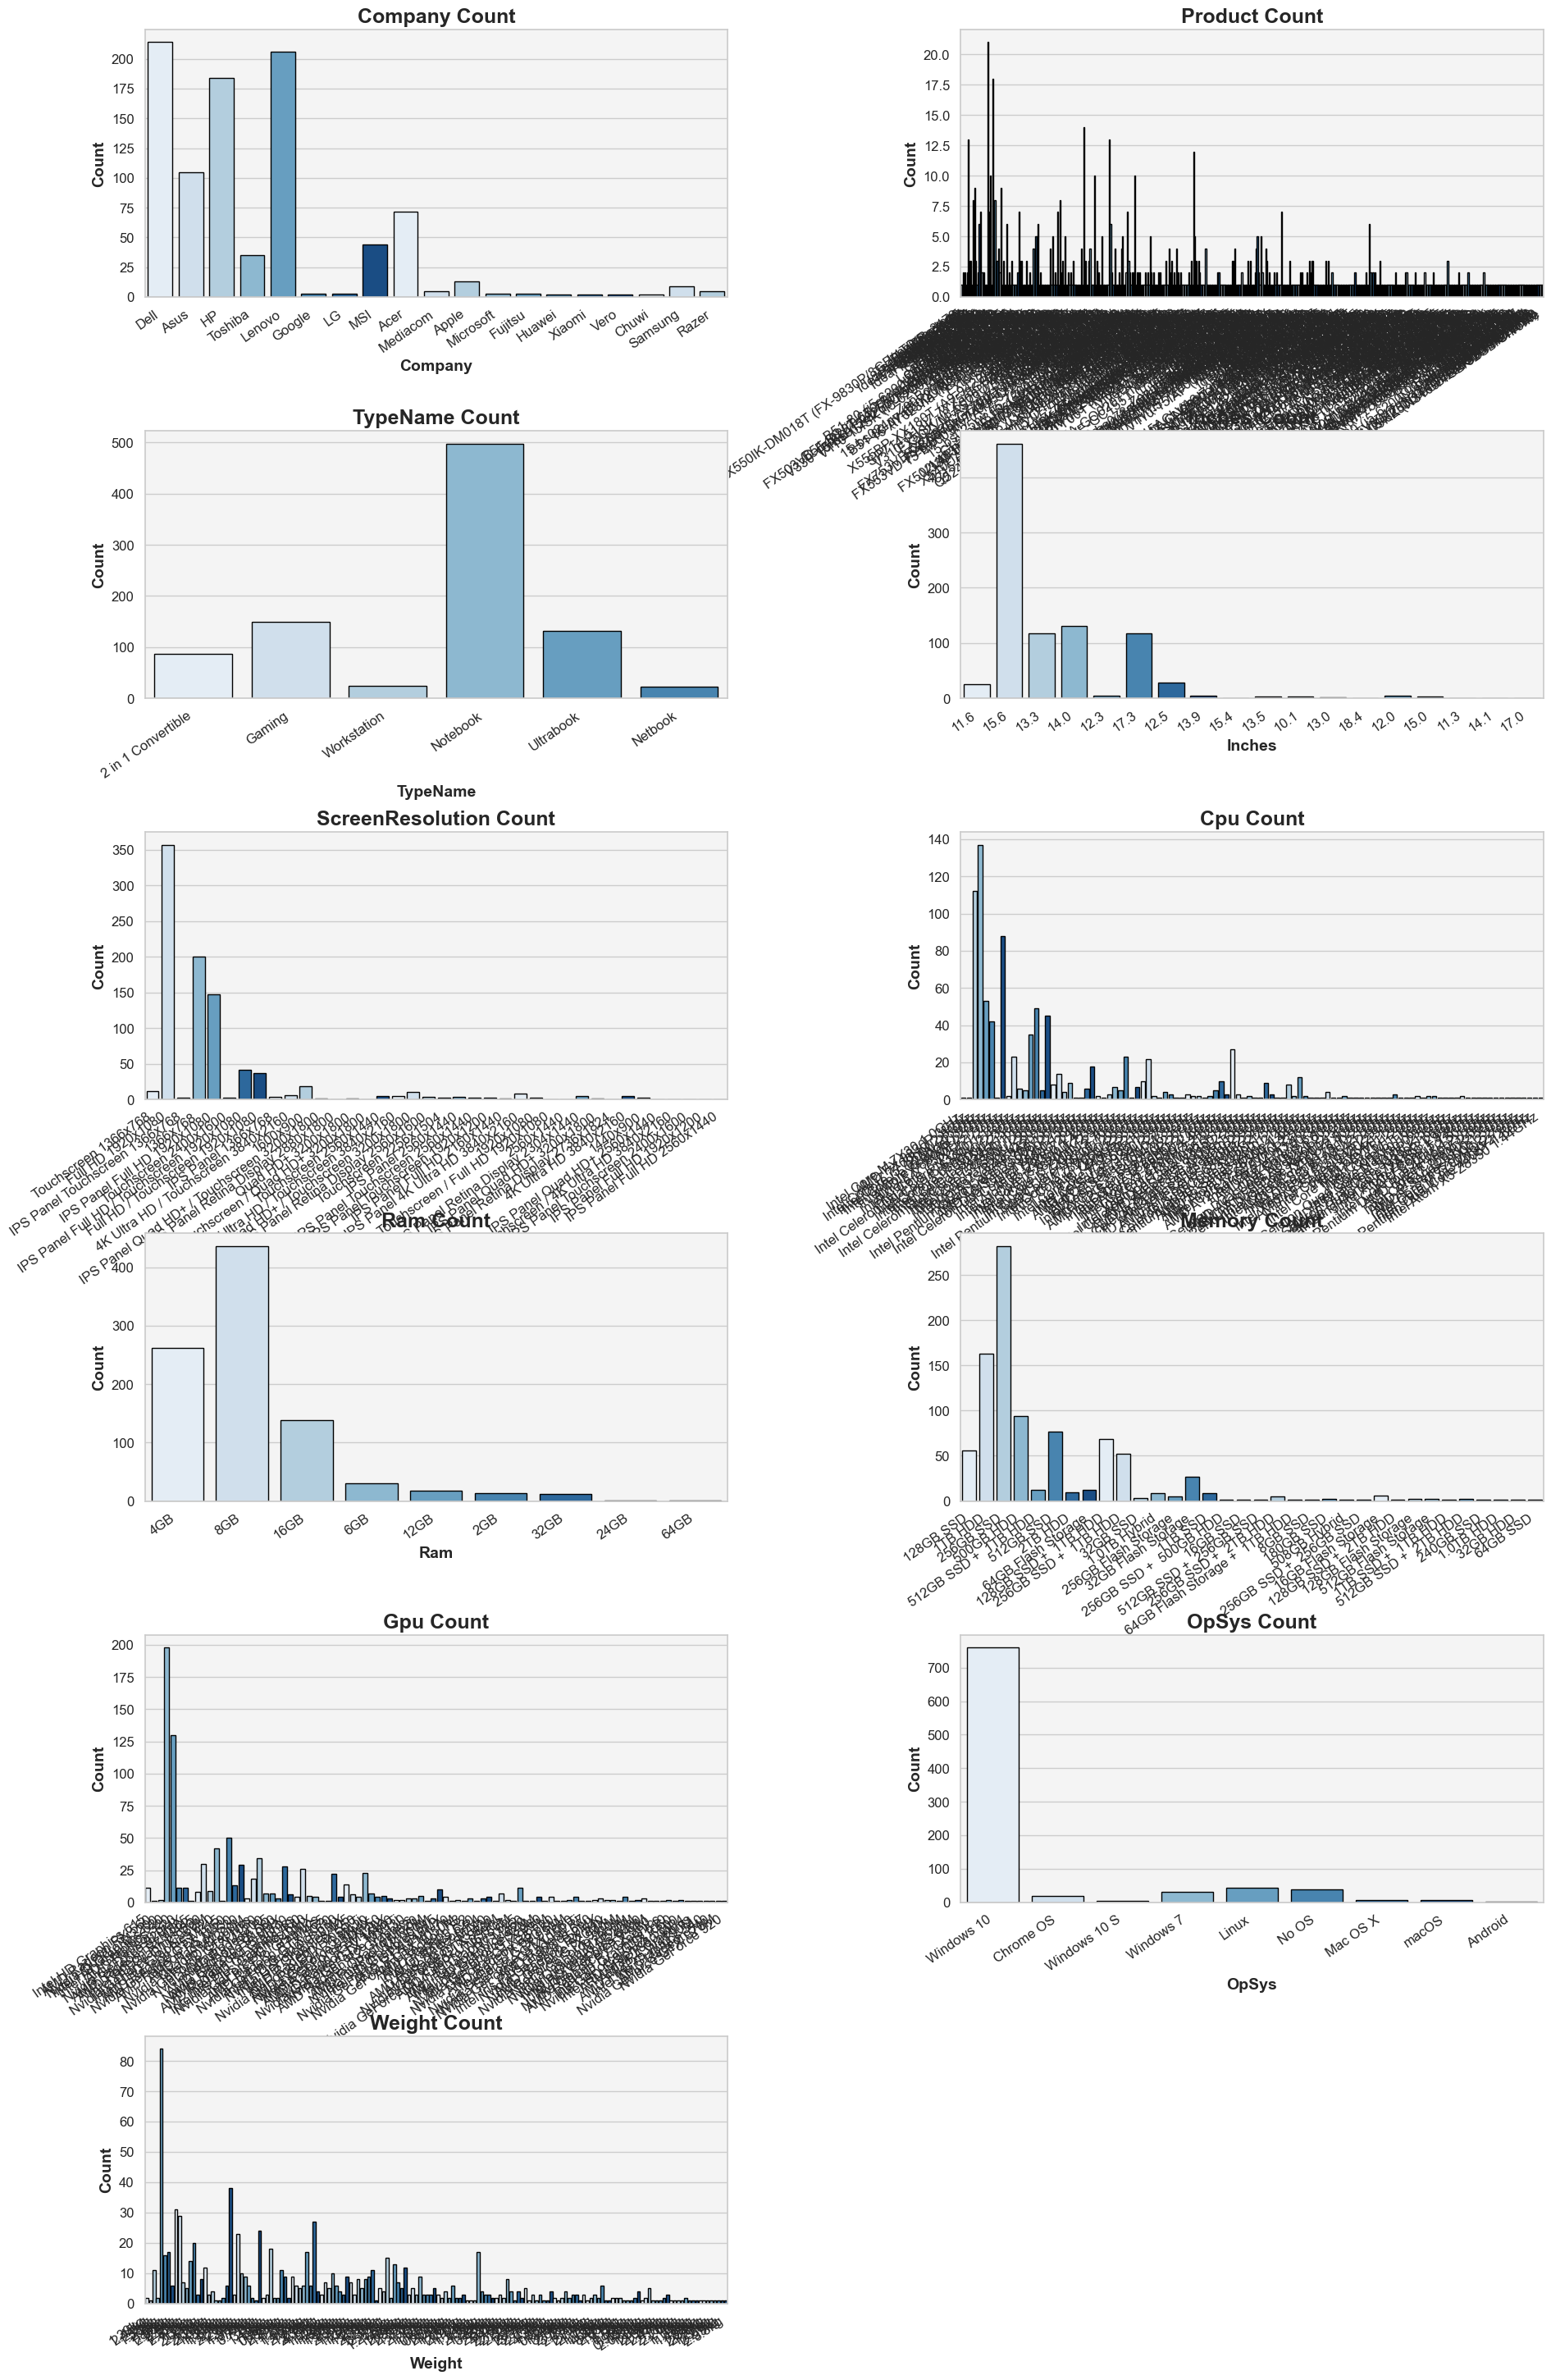

In [70]:
warnings.filterwarnings("ignore")

# Get categorical columns and exclude 'id'
categorical_columns = df1.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col.lower() != 'id']

# Set a seaborn style for the plot
sns.set(style="whitegrid")

# Determine rows and columns for the subplot grid
num_cols = 2  # Two plots per row
num_rows = (len(categorical_columns) // num_cols) + (len(categorical_columns) % num_cols > 0)

# Create figure and axes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(22, 6 * num_rows))
axes = axes.flatten()  # Flatten axes for easy indexing# Use a visually balanced color palette
colors = sns.color_palette("Blues", n_colors=8)

# Plot count plots for each categorical column
for i, col in enumerate(categorical_columns):
    # Increase the size of the "City" plot for better readability
    if col.lower() == 'city':
        sns.countplot(data=df1, x=col, ax=axes[i], palette=colors, order=df[col].value_counts().iloc[:10].index)  # Top 10 cities only
        axes[i].set_title(f'{col} Count', fontsize=18, fontweight='bold')
    else:
        sns.countplot(data=df1, x=col, ax=axes[i], palette=colors)
        axes[i].set_title(f'{col} Count', fontsize=18, fontweight='bold')
        # Set labels
    axes[i].set_xlabel(col, fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Count', fontsize=14, fontweight='bold')
    
    # Rotate x-axis labels for readability
    axes[i].tick_params(axis='x', rotation=35, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

    # Align x-axis labels horizontally to avoid overlap
    for label in axes[i].get_xticklabels():
        label.set_horizontalalignment('right')

    # Set bar edge color
    for bar in axes[i].patches:
        bar.set_edgecolor('black')

    # Set a soft gray background for subplot
    axes[i].set_facecolor('#f4f4f4')
    # Remove unused axes if any
for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Show the plot
plt.show()

## Agrupar por columnas

In [71]:
#ScreenResolution
#Agrupar las medidas en una nueva columna
df1['Resolución'] = df1['ScreenResolution'].apply(
    lambda x: re.search(r'(\d{3,4}x\d{3,4})', x).group(0) if re.search(r'(\d{3,4}x\d{3,4})', x) else None)
#Crear otra variable para características de la pantalla

In [72]:
# Extraer y crear nuevas columnas
df1['tipo_pantalla'] = df1['ScreenResolution'].str.extract(r'^(\w+)')

In [73]:
df1['tipo_pantalla'] = df1['tipo_pantalla'].replace({
    '1366x768': 'HD',
    '1600x900':'HD+',
    '1920x1080':'Full HD',
    '1440x900':'WXGA+',
    '2560x1440':'Quad-HD'
    })

In [74]:
df1['memoria'] = df1['Memory'].str.extract(r'^(\w+)')
df1['tipo_memoria'] = df1['Memory'].str.extract(r"([A-Za-z]+)$")
df1['tipo_memoria'].value_counts()

tipo_memoria
SSD        435
HDD        413
Storage     54
Hybrid      10
Name: count, dtype: int64

In [75]:
df1['tipo_cpu'] = df1['Cpu'].str.extract(r'^(.*)\s')
df1['tipo_cpu'].value_counts()

tipo_cpu
Intel Core i5 7200U              139
Intel Core i7 7700HQ             113
Intel Core i7 7500U               89
Intel Core i3 6006U               56
Intel Core i5 6200U               53
                                ... 
AMD E-Series 6110                  1
AMD E-Series 9000                  1
Intel Core M m3-7Y30               1
Intel Pentium Dual Core 4405Y      1
Intel Atom X5-Z8350                1
Name: count, Length: 87, dtype: int64

In [76]:
df1[['Marca_cpu', 'Serie_cpu', 'Modelo_cpu']] = df1['tipo_cpu'].str.extract(
    r'^(Intel|AMD)\s+([\w\-]+(?:\s[\w\-]+)?)\s+(.*)$')

In [77]:
# Comprobar si todo esta GB
cantidad_con_ghz = df1['Cpu'].str.contains('GHz', case=False).sum()
print(f"Valores con 'GHz': {cantidad_con_ghz} de {len(df1)}")
#Sacar la velocidad de cpu
df1['velocidad_cpu_ghz'] = df1['Cpu'].str.extract(r'(\d+(?:\.\d+)?)GHz')

Valores con 'GHz': 912 de 912


In [78]:
#Gpu
df1[['marca_gpu', 'modelo_gpu']] = df1['Gpu'].str.extract(r'(\w+) (.*)')
df1['modelo_gpu'].value_counts()

modelo_gpu
HD Graphics 620      198
HD Graphics 520      130
GeForce GTX 1050      50
UHD Graphics 620      42
GeForce GTX 1060      34
                    ... 
FirePro W4190M         1
Iris Graphics 540      1
Radeon 540             1
GeForce GTX 970M       1
GeForce 920            1
Name: count, Length: 94, dtype: int64

In [79]:
#OpSys
df1['OpSys_general']= df1['OpSys'].replace({
    'Windows 10':'Windows',
    'Windows 7':'Windows',
    'Windows 10 S':'Windows',
    'Linux':'Linux',
    'MacOS':'MacOS',
    'Mac OS X':'MacOS',
    'Android':'Android',
    'Chrome OS':'Chrome OS',
    'No OS':'Sin OS'
    })

In [80]:
df1.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Resolución,tipo_pantalla,memoria,tipo_memoria,tipo_cpu,Marca_cpu,Serie_cpu,Modelo_cpu,velocidad_cpu_ghz,marca_gpu,modelo_gpu,OpSys_general
0,599,Dell,Inspiron 3179,2 in 1 Convertible,11.6,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,4GB,128GB SSD,Intel HD Graphics 615,Windows 10,1.39kg,603.0,1366x768,Touchscreen,128GB,SSD,Intel Core M 7Y30,Intel,Core M,7Y30,1.0,Intel,HD Graphics 615,Windows
1,92,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,Gaming,15.6,Full HD 1920x1080,AMD FX 9830P 3GHz,8GB,1TB HDD,AMD Radeon RX 560,Windows 10,2.45kg,699.0,1920x1080,Full,1TB,HDD,AMD FX 9830P,AMD,FX,9830P,3,AMD,Radeon RX 560,Windows
2,744,HP,ZBook 15,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD,Nvidia Quadro M2200,Windows 10,2.6kg,2419.0,1920x1080,Full,256GB,SSD,Intel Core i7 7700HQ,Intel,Core i7,7700HQ,2.8,Nvidia,Quadro M2200,Windows
3,729,HP,Pavilion X360,2 in 1 Convertible,13.3,IPS Panel Touchscreen 1366x768,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.58kg,836.6,1366x768,IPS,256GB,SSD,Intel Core i5 7200U,Intel,Core i5,7200U,2.5,Intel,HD Graphics 620,Windows
4,957,Toshiba,Tecra A50-C-1ZV,Notebook,15.6,1366x768,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,2.2kg,1119.0,1366x768,HD,256GB,SSD,Intel Core i5 6200U,Intel,Core i5,6200U,2.3,Intel,HD Graphics 520,Windows


El tipo_cpu es lo más importamte a la hora de determinar el precio del ordenador

#### Agrupar por Ram

In [81]:
df1.groupby('Ram').size()

Ram
12GB     18
16GB    138
24GB      1
2GB      14
32GB     12
4GB     262
64GB      1
6GB      30
8GB     436
dtype: int64

In [82]:
ram= {
    '12GB':0,
    '16GB':1,
    '24GB':2,
    '2GB':3,
    '32GB':4,
    '4GB':5,
    '64GB':6,
    '6GB':7,
    '8GB':8
}
df1.head(2)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Resolución,tipo_pantalla,memoria,tipo_memoria,tipo_cpu,Marca_cpu,Serie_cpu,Modelo_cpu,velocidad_cpu_ghz,marca_gpu,modelo_gpu,OpSys_general
0,599,Dell,Inspiron 3179,2 in 1 Convertible,11.6,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,4GB,128GB SSD,Intel HD Graphics 615,Windows 10,1.39kg,603.0,1366x768,Touchscreen,128GB,SSD,Intel Core M 7Y30,Intel,Core M,7Y30,1.0,Intel,HD Graphics 615,Windows
1,92,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,Gaming,15.6,Full HD 1920x1080,AMD FX 9830P 3GHz,8GB,1TB HDD,AMD Radeon RX 560,Windows 10,2.45kg,699.0,1920x1080,Full,1TB,HDD,AMD FX 9830P,AMD,FX,9830P,3,AMD,Radeon RX 560,Windows


In [83]:
df1['Ram'].value_counts(normalize=True)

Ram
8GB     0.478070
4GB     0.287281
16GB    0.151316
6GB     0.032895
12GB    0.019737
2GB     0.015351
32GB    0.013158
24GB    0.001096
64GB    0.001096
Name: proportion, dtype: float64

In [84]:
df1['Ram'] = df1['Ram'].replace(ram)
df1['Ram'] = df1['Ram'].astype(int)
df1.head(3)


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Resolución,tipo_pantalla,memoria,tipo_memoria,tipo_cpu,Marca_cpu,Serie_cpu,Modelo_cpu,velocidad_cpu_ghz,marca_gpu,modelo_gpu,OpSys_general
0,599,Dell,Inspiron 3179,2 in 1 Convertible,11.6,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,5,128GB SSD,Intel HD Graphics 615,Windows 10,1.39kg,603.0,1366x768,Touchscreen,128GB,SSD,Intel Core M 7Y30,Intel,Core M,7Y30,1.0,Intel,HD Graphics 615,Windows
1,92,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,Gaming,15.6,Full HD 1920x1080,AMD FX 9830P 3GHz,8,1TB HDD,AMD Radeon RX 560,Windows 10,2.45kg,699.0,1920x1080,Full,1TB,HDD,AMD FX 9830P,AMD,FX,9830P,3,AMD,Radeon RX 560,Windows
2,744,HP,ZBook 15,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,1,256GB SSD,Nvidia Quadro M2200,Windows 10,2.6kg,2419.0,1920x1080,Full,256GB,SSD,Intel Core i7 7700HQ,Intel,Core i7,7700HQ,2.8,Nvidia,Quadro M2200,Windows


Agrupación por sistemas operativos

In [85]:
#df1.groupby('OpSys').size()

In [86]:
# No está mal pero sesga los datos
#sistema_operativo = {
#    'Android': 0,           
 #   'Chrome OS': 1,        
  #  'Linux': 2,            
   # 'Mac OS X' or 'macOS': 3,          
   # 'No OS': 4,            
   # 'Windows 10' or'Windows 10 S' or 'Windows': 5    
#}

In [87]:
#df1['OpSys'] = df1['OpSys'].replace(sistema_operativo)
#df1.head(2)

In [88]:
df1.groupby('TypeName').size()

TypeName
2 in 1 Convertible     87
Gaming                149
Netbook                22
Notebook              498
Ultrabook             132
Workstation            24
dtype: int64

In [89]:
nombres= {
    '2 in 1 Convertible': 0,
    'Gaming': 1,
    'Netbook': 2,                 
    'Notebook': 3,             
    'Ultrabooks': 4 ,             
    'Workstation': 5  
}

In [90]:
df1['TypeName'] = df1['TypeName'].replace(nombres)
df1.head(2)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Resolución,tipo_pantalla,memoria,tipo_memoria,tipo_cpu,Marca_cpu,Serie_cpu,Modelo_cpu,velocidad_cpu_ghz,marca_gpu,modelo_gpu,OpSys_general
0,599,Dell,Inspiron 3179,0,11.6,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,5,128GB SSD,Intel HD Graphics 615,Windows 10,1.39kg,603.0,1366x768,Touchscreen,128GB,SSD,Intel Core M 7Y30,Intel,Core M,7Y30,1.0,Intel,HD Graphics 615,Windows
1,92,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,1,15.6,Full HD 1920x1080,AMD FX 9830P 3GHz,8,1TB HDD,AMD Radeon RX 560,Windows 10,2.45kg,699.0,1920x1080,Full,1TB,HDD,AMD FX 9830P,AMD,FX,9830P,3,AMD,Radeon RX 560,Windows


In [91]:
df1.groupby('Inches').size()

Inches
10.1      3
11.3      1
11.6     25
12.0      5
12.3      5
12.5     28
13.0      2
13.3    117
13.5      3
13.9      5
14.0    131
14.1      1
15.0      4
15.4      1
15.6    461
17.0      1
17.3    118
18.4      1
dtype: int64

In [92]:
df1.set_index('laptop_ID')

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Resolución,tipo_pantalla,memoria,tipo_memoria,tipo_cpu,Marca_cpu,Serie_cpu,Modelo_cpu,velocidad_cpu_ghz,marca_gpu,modelo_gpu,OpSys_general
laptop_ID,,,,,,,,,,,,,,,,,,,,,,,,
599,Dell,Inspiron 3179,0,11.6,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,5,128GB SSD,Intel HD Graphics 615,Windows 10,1.39kg,603.00,1366x768,Touchscreen,128GB,SSD,Intel Core M 7Y30,Intel,Core M,7Y30,1.0,Intel,HD Graphics 615,Windows
92,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,1,15.6,Full HD 1920x1080,AMD FX 9830P 3GHz,8,1TB HDD,AMD Radeon RX 560,Windows 10,2.45kg,699.00,1920x1080,Full,1TB,HDD,AMD FX 9830P,AMD,FX,9830P,3,AMD,Radeon RX 560,Windows
744,HP,ZBook 15,5,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,1,256GB SSD,Nvidia Quadro M2200,Windows 10,2.6kg,2419.00,1920x1080,Full,256GB,SSD,Intel Core i7 7700HQ,Intel,Core i7,7700HQ,2.8,Nvidia,Quadro M2200,Windows
729,HP,Pavilion X360,0,13.3,IPS Panel Touchscreen 1366x768,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,Windows 10,1.58kg,836.60,1366x768,IPS,256GB,SSD,Intel Core i5 7200U,Intel,Core i5,7200U,2.5,Intel,HD Graphics 620,Windows
957,Toshiba,Tecra A50-C-1ZV,3,15.6,1366x768,Intel Core i5 6200U 2.3GHz,8,256GB SSD,Intel HD Graphics 520,Windows 10,2.2kg,1119.00,1366x768,HD,256GB,SSD,Intel Core i5 6200U,Intel,Core i5,6200U,2.3,Intel,HD Graphics 520,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,Acer,Chromebook 11,2,11.6,IPS Panel 1366x768,Intel Celeron Dual Core N3060 1.6GHz,5,32GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.35kg,355.00,1366x768,IPS,32GB,Storage,Intel Celeron Dual Core N3060,Intel,Celeron Dual,Core N3060,1.6,Intel,HD Graphics 400,Chrome OS
626,Acer,CB5-132T-C9KK (N3160/4GB/32GB/Chrome,0,11.6,IPS Panel Touchscreen 1366x768,Intel Celeron Quad Core N3160 1.6GHz,5,32GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.25kg,379.00,1366x768,IPS,32GB,Storage,Intel Celeron Quad Core N3160,Intel,Celeron Quad,Core N3160,1.6,Intel,HD Graphics 400,Chrome OS
225,Dell,Inspiron 3576,3,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8,256GB SSD,AMD Radeon 520,Linux,2.2kg,677.35,1920x1080,Full,256GB,SSD,Intel Core i5 8250U,Intel,Core i5,8250U,1.6,AMD,Radeon 520,Linux


Agrupaciones por precio

In [93]:
df1['rangos_precio']= df1['Price_euros'].replace({
    '- =500':1,
    '- =1000':2,
    '-= 2000':3,
    '> 2000':4,
    })

df1.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Resolución,tipo_pantalla,memoria,tipo_memoria,tipo_cpu,Marca_cpu,Serie_cpu,Modelo_cpu,velocidad_cpu_ghz,marca_gpu,modelo_gpu,OpSys_general,rangos_precio
0,599,Dell,Inspiron 3179,0,11.6,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,5,128GB SSD,Intel HD Graphics 615,Windows 10,1.39kg,603.0,1366x768,Touchscreen,128GB,SSD,Intel Core M 7Y30,Intel,Core M,7Y30,1.0,Intel,HD Graphics 615,Windows,603.0
1,92,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,1,15.6,Full HD 1920x1080,AMD FX 9830P 3GHz,8,1TB HDD,AMD Radeon RX 560,Windows 10,2.45kg,699.0,1920x1080,Full,1TB,HDD,AMD FX 9830P,AMD,FX,9830P,3,AMD,Radeon RX 560,Windows,699.0
2,744,HP,ZBook 15,5,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,1,256GB SSD,Nvidia Quadro M2200,Windows 10,2.6kg,2419.0,1920x1080,Full,256GB,SSD,Intel Core i7 7700HQ,Intel,Core i7,7700HQ,2.8,Nvidia,Quadro M2200,Windows,2419.0
3,729,HP,Pavilion X360,0,13.3,IPS Panel Touchscreen 1366x768,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,Windows 10,1.58kg,836.6,1366x768,IPS,256GB,SSD,Intel Core i5 7200U,Intel,Core i5,7200U,2.5,Intel,HD Graphics 620,Windows,836.6
4,957,Toshiba,Tecra A50-C-1ZV,3,15.6,1366x768,Intel Core i5 6200U 2.3GHz,8,256GB SSD,Intel HD Graphics 520,Windows 10,2.2kg,1119.0,1366x768,HD,256GB,SSD,Intel Core i5 6200U,Intel,Core i5,6200U,2.3,Intel,HD Graphics 520,Windows,1119.0


### GUARDAR DATAFRAME

In [95]:
# Guardar el DataFrame en un nuevo archivo CSV
df1.to_csv(r'C:\Users\nuria\OneDrive\Escritorio\Data Science\DS102024\3-MachineLearning\2-Supervisado\1-Clasificacion\train_modificado.csv', index=False)

### Ampliación de columnas¿?

In [90]:
# Los tipos únicos de 'TypeName'
tipos = ['2 in 1 Convertible', 'Gaming', 'Netbook', 'Notebook', 'Ultrabook', 'Workstation']

# Columnas binarias para cada tipo
for tipo in tipos:
    df1[tipo] = df1['TypeName'].apply(lambda x: 1 if x == tipo else 0)

# Eliminar la columna original si ya no la necesitas
# df = df.drop(columns=['TypeName'])

df1.head(2)


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,2 in 1 Convertible,Gaming,Netbook,Notebook,Ultrabook,Workstation
0,599,Dell,Inspiron 3179,0,11.6,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,5,128GB SSD,Intel HD Graphics 615,5,1.39kg,603.0,0,0,0,0,0,0
1,92,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,1,15.6,Full HD 1920x1080,AMD FX 9830P 3GHz,8,1TB HDD,AMD Radeon RX 560,5,2.45kg,699.0,0,0,0,0,0,0


In [96]:
df = pd.read_csv(r'C:\Users\nuria\OneDrive\Escritorio\Data Science\DS102024\3-MachineLearning\2-Supervisado\1-Clasificacion\train_modificado.csv')
df.head(3)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Resolución,tipo_pantalla,memoria,tipo_memoria,tipo_cpu,Marca_cpu,Serie_cpu,Modelo_cpu,velocidad_cpu_ghz,marca_gpu,modelo_gpu,OpSys_general,rangos_precio
0,599,Dell,Inspiron 3179,0,11.6,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,5,128GB SSD,Intel HD Graphics 615,Windows 10,1.39kg,603.0,1366x768,Touchscreen,128GB,SSD,Intel Core M 7Y30,Intel,Core M,7Y30,1.0,Intel,HD Graphics 615,Windows,603.0
1,92,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,1,15.6,Full HD 1920x1080,AMD FX 9830P 3GHz,8,1TB HDD,AMD Radeon RX 560,Windows 10,2.45kg,699.0,1920x1080,Full,1TB,HDD,AMD FX 9830P,AMD,FX,9830P,3.0,AMD,Radeon RX 560,Windows,699.0
2,744,HP,ZBook 15,5,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,1,256GB SSD,Nvidia Quadro M2200,Windows 10,2.6kg,2419.0,1920x1080,Full,256GB,SSD,Intel Core i7 7700HQ,Intel,Core i7,7700HQ,2.8,Nvidia,Quadro M2200,Windows,2419.0


In [31]:
print(df.groupby('Ram').size())
print(df.groupby('TypeName').size())
print(df.groupby('OpSys').size())

Ram
0     18
1    138
2      1
3     14
4     12
5    262
6      1
7     30
8    436
dtype: int64
TypeName
2 in 1 Convertible     87
Gaming                149
Netbook                22
Notebook              498
Ultrabook             132
Workstation            24
dtype: int64
OpSys
Android           1
Chrome OS        20
Linux            43
Mac OS X          7
No OS            39
Windows 10      760
Windows 10 S      5
Windows 7        31
macOS             6
dtype: int64


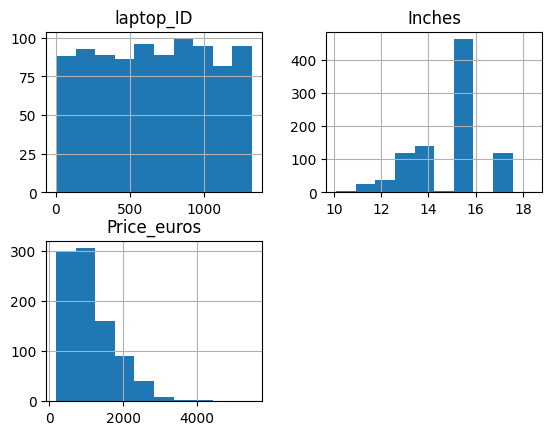

In [87]:
df.drop(columns=['Ram']).hist()
plt.show()

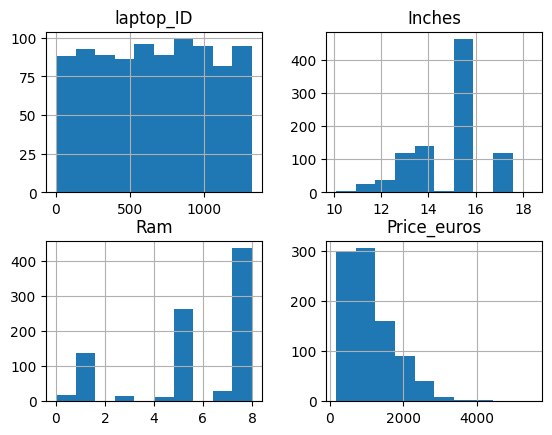

In [88]:
df.drop(columns=['TypeName']).hist()
plt.show()

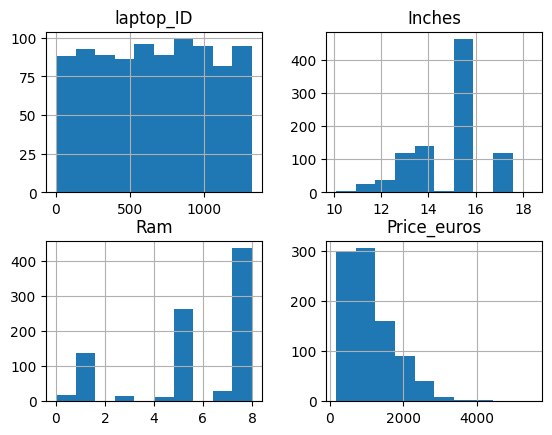

In [89]:
df.drop(columns=['OpSys']).hist()
plt.show()

- Los datos no tienen una distribución normal

In [97]:
df.isnull().sum()

laptop_ID            0
Company              0
Product              0
TypeName             0
Inches               0
ScreenResolution     0
Cpu                  0
Ram                  0
Memory               0
Gpu                  0
OpSys                0
Weight               0
Price_euros          0
Resolución           0
tipo_pantalla        0
memoria              0
tipo_memoria         0
tipo_cpu             0
Marca_cpu            1
Serie_cpu            1
Modelo_cpu           1
velocidad_cpu_ghz    0
marca_gpu            0
modelo_gpu           0
OpSys_general        0
rangos_precio        0
dtype: int64

In [103]:
# Se importan los valores faltantes a la moda (el más repetido)
df['Marca_cpu'].fillna(df['Marca_cpu'].mode()[0])
df['Serie_cpu'].fillna(df['Serie_cpu'].mode()[0])
df['Modelo_cpu'].fillna(df['Modelo_cpu'].mode()[0])

0      Intel
1        AMD
2      Intel
3      Intel
4      Intel
       ...  
907    Intel
908    Intel
909    Intel
910    Intel
911    Intel
Name: Marca_cpu, Length: 912, dtype: object

In [101]:
# Convertir 'OpSys' a numérico usando el método de codificación
df['OpSys'] = df['OpSys'].astype('category').cat.codes
df['velocidad_cpu_ghz'] = df['velocidad_cpu_ghz'].astype('category').cat.codes

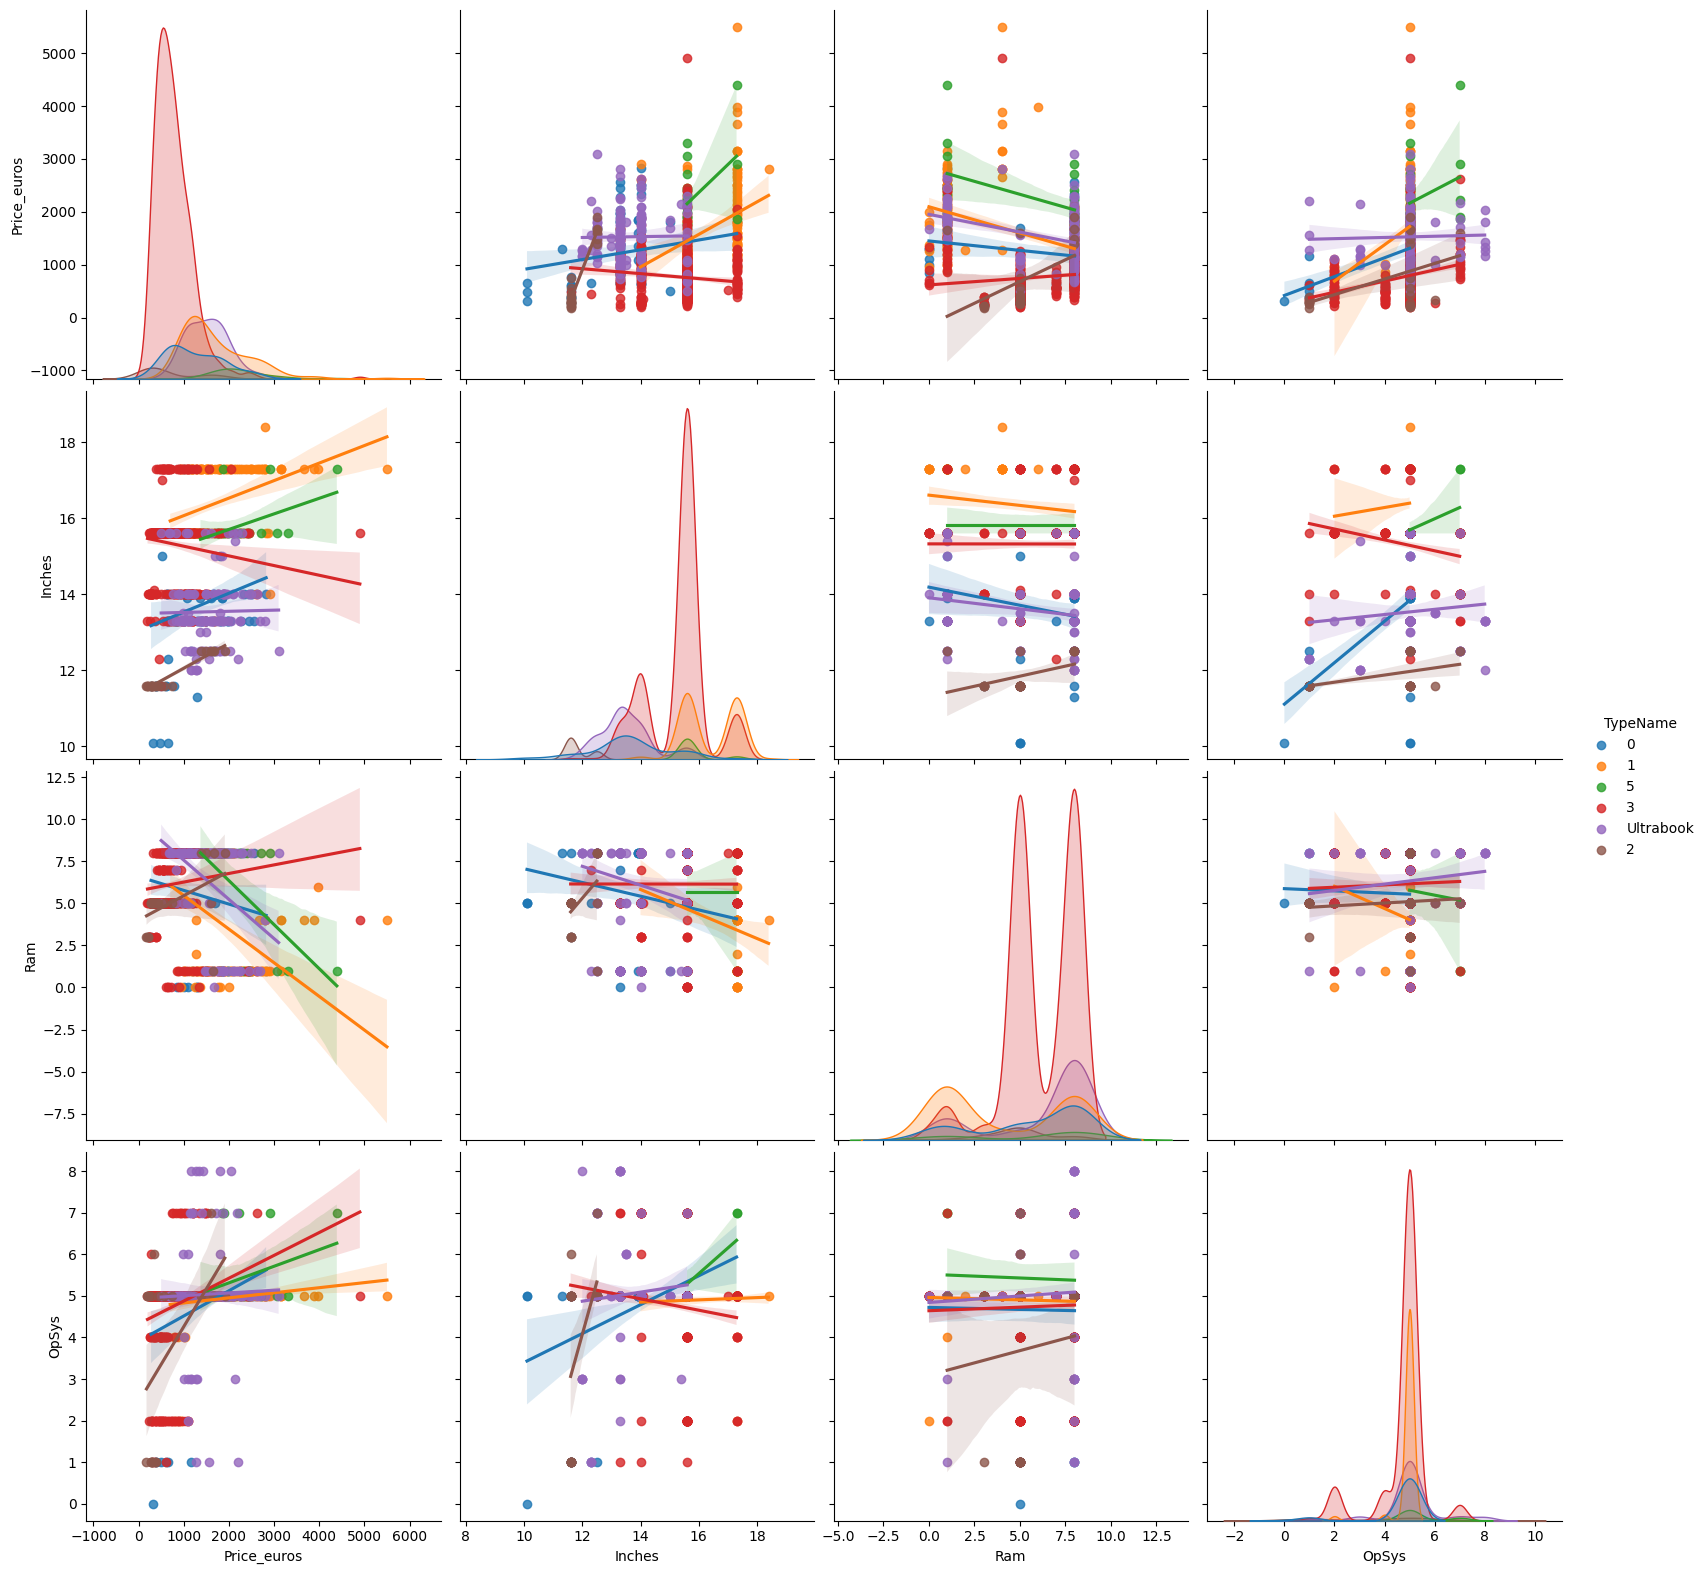

In [96]:
sns.pairplot(df.dropna(),
            hue='TypeName', # Para que lo separe por clase
            height=4,
            vars=["Price_euros","Inches","Ram", "OpSys"],
            kind='reg');

In [35]:
print(df.dtypes)

laptop_ID              int64
Company               object
Product               object
TypeName              object
Inches               float64
ScreenResolution      object
Cpu                   object
Ram                    int64
Memory                object
Gpu                   object
OpSys                   int8
Weight                object
Price_euros          float64
tipo_pantalla         object
memoria               object
tipo_memoria          object
tipo_cpu              object
Marca_cpu             object
Serie_cpu             object
Modelo_cpu            object
velocidad_cpu_ghz       int8
marca_gpu             object
modelo_gpu            object
OpSys_general         object
dtype: object


In [36]:
# Convertir todas las columnas a numéricas, forzando a NaN donde no se pueda
df_numeric = df.apply(pd.to_numeric, errors='coerce')


In [42]:
df.head(2)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,...,memoria,tipo_memoria,tipo_cpu,Marca_cpu,Serie_cpu,Modelo_cpu,velocidad_cpu_ghz,marca_gpu,modelo_gpu,OpSys_general
0,599,Dell,Inspiron 3179,2 in 1 Convertible,11.6,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,5,128GB SSD,Intel HD Graphics 615,...,128GB,SSD,Intel Core M 7Y30,Intel,Core M,7Y30,1,Intel,HD Graphics 615,Windows
1,92,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,Gaming,15.6,Full HD 1920x1080,AMD FX 9830P 3GHz,8,1TB HDD,AMD Radeon RX 560,...,1TB,HDD,AMD FX 9830P,AMD,FX,9830P,21,AMD,Radeon RX 560,Windows


## Procesado para ML

In [106]:
df.select_dtypes(include='object').head(2)

,Company,Product,TypeName,ScreenResolution,Cpu,Memory,Gpu,Weight,Resolución,tipo_pantalla,memoria,tipo_memoria,tipo_cpu,Marca_cpu,Serie_cpu,Modelo_cpu,marca_gpu,modelo_gpu,OpSys_general
0,Dell,Inspiron 3179,0,Touchscreen 1366x768,Intel Core M 7Y30 1.0GHz,128GB SSD,Intel HD Graphics 615,1.39kg,1366x768,Touchscreen,128GB,SSD,Intel Core M 7Y30,Intel,Core M,7Y30,Intel,HD Graphics 615,Windows
1,Asus,FX550IK-DM018T (FX-9830P/8GB/1TB/Radeon,1,Full HD 1920x1080,AMD FX 9830P 3GHz,1TB HDD,AMD Radeon RX 560,2.45kg,1920x1080,Full,1TB,HDD,AMD FX 9830P,AMD,FX,9830P,AMD,Radeon RX 560,Windows


In [105]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Supongamos que 'categorical_features' es una lista de las columnas categóricas
categorical_features = ['modelo_gpu', 'nombre_columna_categórica2']
numeric_features = ['nombre_columna_numérica1', 'nombre_columna_numérica2']

# Crear un transformador para las características
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Crear el pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(max_iter=2000))])

# Ajustar el modelo
model.fit(X, y)


ValueError: Specifying the columns using strings is only supported for dataframes.

## Creación del modelo ML

In [37]:
from sklearn.linear_model import LogisticRegression

In [104]:
X = np.array(df.drop(columns=['velocidad_cpu_ghz'])) # La x es todo menos el nombre
y = np.array(df['velocidad_cpu_ghz']) # La y es el nombre

In [40]:
# Modelo instanciado
model = LogisticRegression(max_iter=2000) # El max_iter te hace las interacciones que quieras y QUITA EL WARNING DE PREDICCIÓN MENOS PRECISA

# Modelo entrenado
model.fit(X, y) #Cuanto mayor sea el iter mas prediccion tendra pero hay que tener cuidado con el over trained

ValueError: could not convert string to float: 'Dell'